# EDA Notebook

##### During cleaning in the previous notebook, we already did some EDA. In this notebook, we focus on doing more quantitative EDA, and we also create a final conglomerated text feature for the model. Then we will apply NLP techniques to the text feature to better understand the language used throughout the corpus documents. 

___

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')

from nltk import bigrams, trigrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer

## Read Data

In [2]:
df = pd.read_csv('../data/scored_data.csv', index_col=0)
df.head()

,audit_observation,status_of_implementation,management_action,references,source,status_score,status
0,9. payments of honoraria to bids and awards co...,implemented,all taxes due have been deducted from honorari...,NaN,09-taysan2013_part3-status_of_py's_recommendat...,1.0,2
1,"1. the cash in bank - local currency, current ...",implemented,the municipal accountant was already instructe...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf,1.0,2
2,2. collectors failed to remit their collection...,partially implemented,a memorandum on the matter was already issued ...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf,0.5,1
3,3. the collections remitted to the municipal t...,partially implemented,a memorandum on the matter was already issued ...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf,0.5,1
4,"4. existence, validity and correctness of the ...",partially implemented,this office has already constituted an invento...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf,0.5,1


## Finalizing Features and Target

In [3]:
# drop the features we don't need
df = df.drop(['references', 'source', 'status_of_implementation', 'status_score'], axis=1)
df.head()

,audit_observation,management_action,status
0,9. payments of honoraria to bids and awards co...,all taxes due have been deducted from honorari...,2
1,"1. the cash in bank - local currency, current ...",the municipal accountant was already instructe...,2
2,2. collectors failed to remit their collection...,a memorandum on the matter was already issued ...,1
3,3. the collections remitted to the municipal t...,a memorandum on the matter was already issued ...,1
4,"4. existence, validity and correctness of the ...",this office has already constituted an invento...,1


In [4]:
# combine observation text data with the management action:
df.audit_observation = df.audit_observation + ' ' + df.management_action.fillna('')
df.drop('management_action', axis=1, inplace=True)

In [5]:
print(df.shape)
df.head()

(4306, 2)


,audit_observation,status
0,9. payments of honoraria to bids and awards co...,2
1,"1. the cash in bank - local currency, current ...",2
2,2. collectors failed to remit their collection...,1
3,3. the collections remitted to the municipal t...,1
4,"4. existence, validity and correctness of the ...",1


### Demonstrate completeness of data

In [6]:
df.isna().sum()

audit_observation    0
status               0
dtype: int64

In [7]:
# no empty strings in the observation column
df.loc[df.audit_observation.apply(lambda x: str(x).strip()=='')] 

,audit_observation,status


In [8]:
# no empty values in the status column
df.loc[df.status.apply(lambda x: str(x).strip()=='')] 

,audit_observation,status


___

## Distribution of `status`

In [9]:
df.status.value_counts()

0    1669
1    1596
2    1041
Name: status, dtype: int64

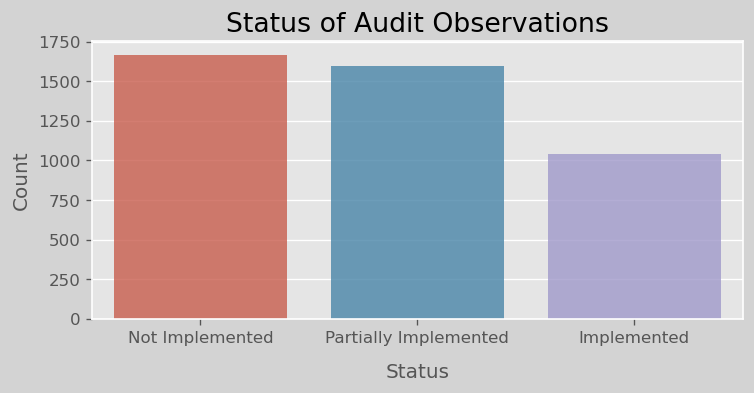

In [10]:
plt.figure(figsize=(7,3), dpi=120, facecolor='lightgray', edgecolor='k')
sns.countplot(x='status', 
              data=df,
              order=df.status.value_counts().index,
              alpha=0.8,
              saturation=0.7)
plt.title('Status of Audit Observations', fontsize=16)
plt.xlabel('Status', fontsize=12, labelpad=10)
plt.xticks(ticks=[0,1,2],labels=['Not Implemented', 'Partially Implemented', 'Implemented'])
plt.ylabel('Count', fontsize=12);

## Distribution of lengths of observations

In [11]:
df['obs_word_len'] = df.audit_observation.apply(lambda x: len(str(x).split()))  # excluding spaces
df['obs_char_len'] = df.audit_observation.apply(lambda x: len(str(x)))  # including spaces

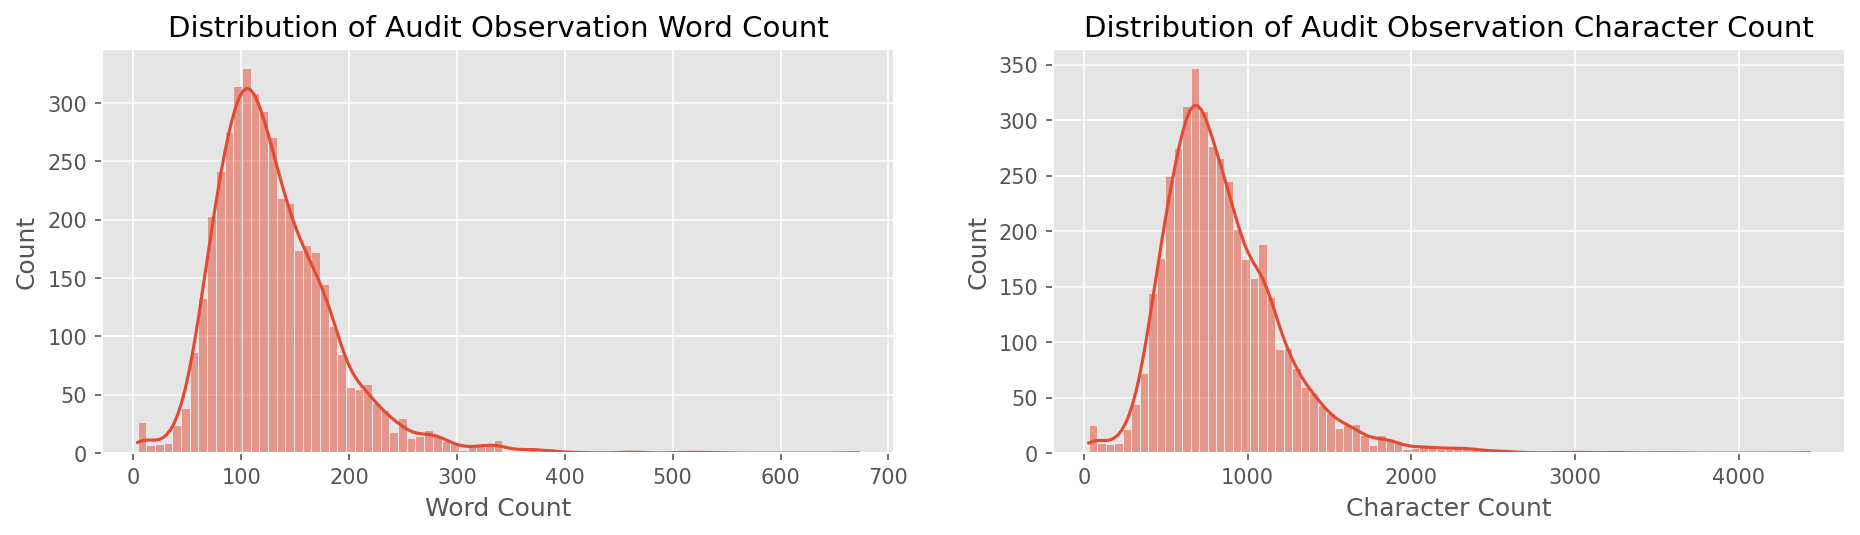

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,3.5), sharey=False, dpi=150)
sns.histplot(x='obs_word_len', data=df, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Audit Observation Word Count', fontsize=14)
axes[0].set_xlabel('Word Count', fontsize=12)
sns.histplot(x='obs_char_len', data=df, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Audit Observation Character Count', fontsize=14)
axes[1].set_xlabel('Character Count', fontsize=12);

> We see a a tiny bit of right skew here, but it's not too bad. Not a whole lot to be gleaned from this other than confirming that there are not a significant number of outliers.

In [13]:
long_observations = df.loc[df.obs_char_len >= df.obs_char_len.quantile(.99)]
print(long_observations.shape)
long_observations.sort_values('obs_char_len', ascending=False).head(10)

(44, 4)


,audit_observation,status,obs_word_len,obs_char_len
2475,"1. the balance of property, plant and equipmen...",1,672,4431
2430,"4. construction in progress account of p23,530...",1,533,3531
1293,4. negative balances of accounts due to bir (4...,1,509,3290
1294,1. the report on the physical count of propert...,1,519,3213
1292,cy 2012 aar 1.due from officers and employees ...,1,470,3044
40,"21. the physical count of property, plant and ...",1,460,2999
219,"as of december 31, 2013, the undeposited colle...",0,453,2900
3913,3. the recorded balances of the real property ...,0,416,2706
1649,5. the accuracy and reliability of the recorde...,0,383,2593
2062,13. errors/ deficiencies committed in recordin...,1,387,2562


___

## Tokenizing `audit_observation`

In [14]:
tokenizer = RegexpTokenizer(r'\w+')  # remove punctuation
def my_tokenizer(text, filter=False):
    tokens = [token.lower() for token in tokenizer.tokenize(text)]
    if filter:
        stopwords_list = stopwords.words('english')
        tokens = [token for token in tokens if token not in stopwords_list]
    return ' '.join(tokens)
my_tokenizer('This is a test sentence. I wrote it to test this function. It has punctuation and stopwords.', filter=True)

'test sentence wrote test function punctuation stopwords'

In [15]:
df['audit_tokens'] = df.audit_observation.apply(lambda x: my_tokenizer(x))
df.audit_tokens.head()

0    9 payments of honoraria to bids and awards com...
1    1 the cash in bank local currency current acco...
2    2 collectors failed to remit their collections...
3    3 the collections remitted to the municipal tr...
4    4 existence validity and correctness of the in...
Name: audit_tokens, dtype: object

In [16]:
df['filtered_tokens'] = df.audit_tokens.apply(lambda x: my_tokenizer(x, filter=True))
df.filtered_tokens.head()

0    9 payments honoraria bids awards committee off...
1    1 cash bank local currency current account sho...
2    2 collectors failed remit collections intact d...
3    3 collections remitted municipal treasurer dep...
4    4 existence validity correctness inventories p...
Name: filtered_tokens, dtype: object

> Great! Now we have tokens for both the filtered and unfiltered observations. We'll do some analysis on token frequency to see if there are any problems with the text data before moving to applying lemmatisation and stemming.

### Token Frequency Analysis

In [17]:
def create_freq_dist_plot(tokens, n=10, title='Most Common Tokens'):
    plt.figure(figsize=(5,3), dpi=100)
    freq_dist = FreqDist(tokens)
    freq_dist.plot(n, title=title)

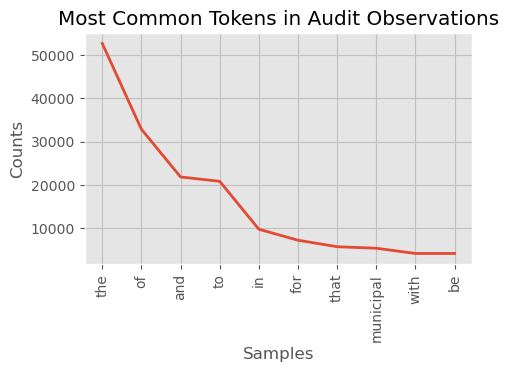

In [18]:
create_freq_dist_plot(df.audit_tokens.sum().split(), title='Most Common Tokens in Audit Observations')

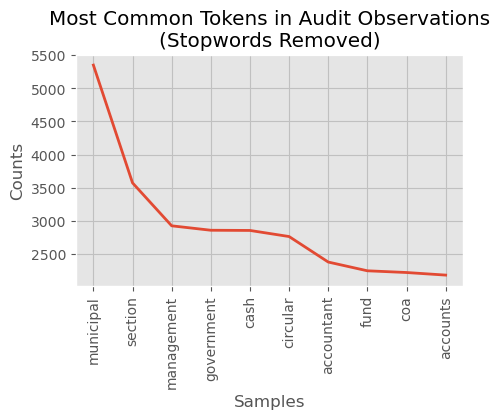

In [19]:
create_freq_dist_plot(df.filtered_tokens.sum().split(), title='Most Common Tokens in Audit Observations\n(Stopwords Removed)')

## Phrase Frequency Analysis

In [20]:
def plot_ngrams(sorted_ngrams, n, top, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8,3.5))
    ax.bar(range(top), [count for _, count in sorted_ngrams[:top]], align='center')
    ax.set_xticks(range(top))
    ax.set_xticklabels([ngram for ngram, _ in sorted_ngrams[:top]], rotation=45, ha='right')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.show()

### Most common bigrams with stop words

In [21]:
bigram_finder = BigramCollocationFinder.from_documents(df.audit_tokens.apply(lambda x: x.split()))
bigram_freq = bigram_finder.ngram_fd.items()
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
bigram_freq[:10]

[(('of', 'the'), 11437),
 (('the', 'municipal'), 4508),
 (('in', 'the'), 4165),
 (('to', 'the'), 4104),
 (('that', 'the'), 2651),
 (('circular', 'no'), 2204),
 (('the', 'municipality'), 2124),
 (('municipal', 'accountant'), 2022),
 (('with', 'the'), 1995),
 (('for', 'the'), 1947)]

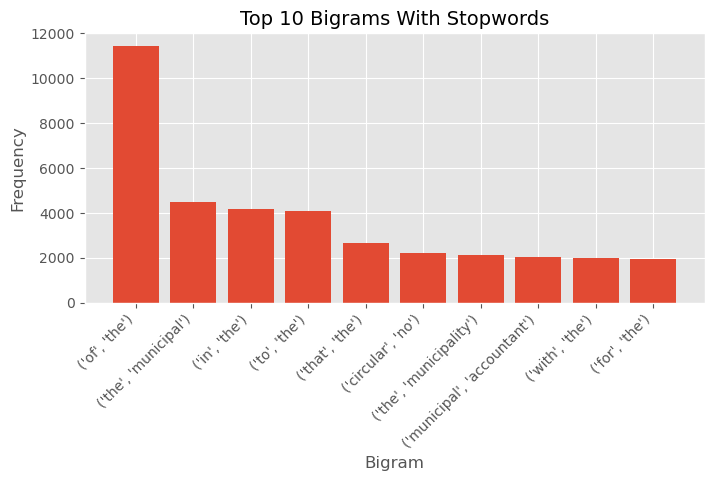

In [22]:
plot_ngrams(bigram_freq, 2, 10, 'Top 10 Bigrams With Stopwords', 'Bigram', 'Frequency')

### Most common bigrams without stop words

In [23]:
bigram_finder = BigramCollocationFinder.from_documents(df.filtered_tokens.apply(lambda x: x.split()))
bigram_freq = bigram_finder.ngram_fd.items()
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
bigram_freq[:10]

[(('municipal', 'accountant'), 2022),
 (('coa', 'circular'), 1840),
 (('cash', 'advances'), 1451),
 (('municipal', 'treasurer'), 1431),
 (('contrary', 'section'), 900),
 (('government', 'accounting'), 890),
 (('plant', 'equipment'), 771),
 (('property', 'plant'), 767),
 (('december', '31'), 738),
 (('accounting', 'system'), 726)]

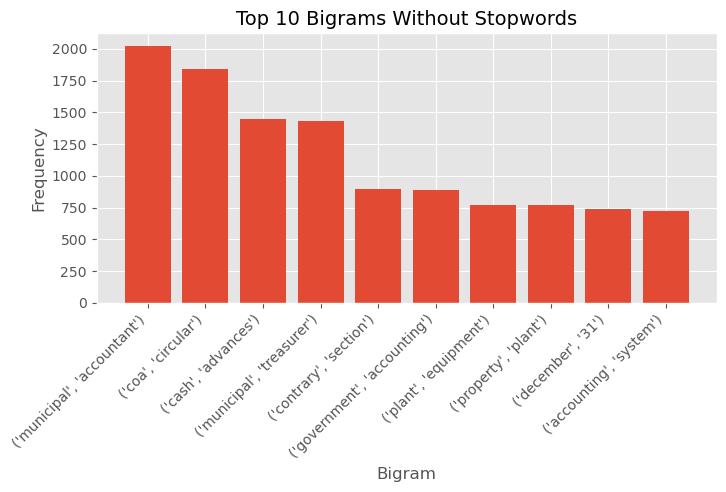

In [24]:
plot_ngrams(bigram_freq, 2, 10, 'Top 10 Bigrams Without Stopwords', 'Bigram', 'Frequency')

### Trigrams Without Stopwords

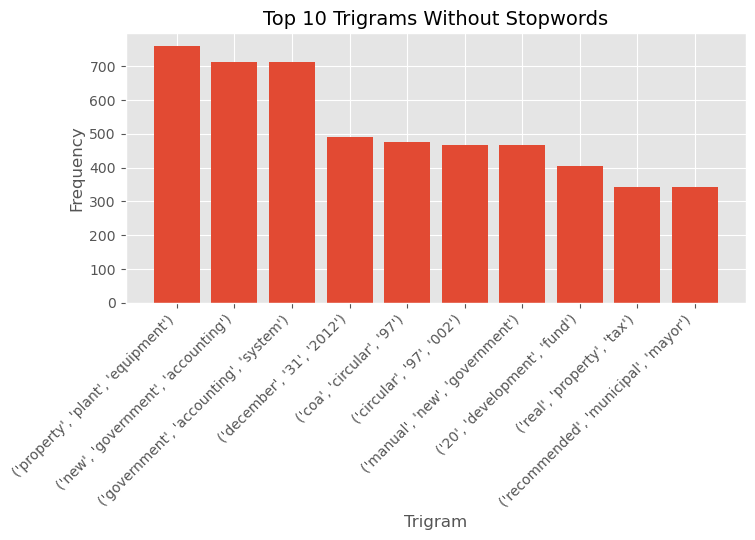

In [25]:
trigram_finder = TrigramCollocationFinder.from_documents(df.filtered_tokens.apply(lambda x: x.split()))
trigram_freq = trigram_finder.ngram_fd.items()
trigram_freq = sorted(trigram_freq, key=lambda x: x[1], reverse=True)
trigram_freq[:10]
plot_ngrams(trigram_freq, 3, 10, 'Top 10 Trigrams Without Stopwords', 'Trigram', 'Frequency')

##### Interpreting the Phrase Frequency Analysis

The most common 2 & 3 grams are maybe not immediately that informative, but they do demonstrate a significant degree of similarity & consistency in the language used between documents. Of course, the plots showing n-grams with filtered tokens as the input are more interesting from this graphical perspective, but seeing a bigram like ('municipal','accountant') in the top 10 despite the presence of stopwords is great. Means our corpus is focused!

___

## Lemmatization and Stemming

In [26]:
def lem_and_stem(text, stemmer=PorterStemmer(), lemmatizer=WordNetLemmatizer()):
    return stemmer.stem(lemmatizer.lemmatize(text))

In [27]:
df['processed_observations'] = df.filtered_tokens.apply(lambda x: ' '.join([lem_and_stem(token) for token in x.split()]))

In [28]:
df.processed_observations.head()

0    9 payment honorarium bid award committe offici...
1    1 cash bank local currenc current account show...
2    2 collector fail remit collect intact daili mu...
3    3 collect remit municip treasur deposit intact...
4    4 exist valid correct inventori ppe account de...
Name: processed_observations, dtype: object

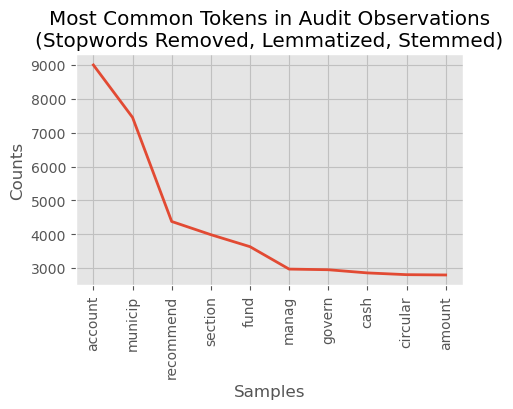

In [29]:
create_freq_dist_plot(df.processed_observations.sum().split(), title='Most Common Tokens in Audit Observations\n(Stopwords Removed, Lemmatized, Stemmed)')

After applying lemmatization and stemming to the tokens, we can see that the most common words are now different. Let's look at the most common words with and without this technique applied.

In [30]:
processed_corpus = df.processed_observations.sum().split()
filtered_corpus = df.filtered_tokens.sum().split()

processed_dist = FreqDist(processed_corpus)
filtered_dist = FreqDist(filtered_corpus)

In [31]:
side_by_side = list(zip(processed_dist.most_common(10), filtered_dist.most_common(10)))
side_by_side

[(('account', 9003), ('municipal', 5350)),
 (('municip', 7453), ('section', 3572)),
 (('recommend', 4375), ('management', 2924)),
 (('section', 3985), ('government', 2857)),
 (('fund', 3630), ('cash', 2854)),
 (('manag', 2967), ('circular', 2762)),
 (('govern', 2948), ('accountant', 2377)),
 (('cash', 2854), ('fund', 2245)),
 (('circular', 2802), ('coa', 2219)),
 (('amount', 2793), ('accounts', 2180))]

> We see here some minimal differences between the **processed** [stopword removal, lemming and stemming] (*left*) and **filtered** [no stop words] (*right*)

In [32]:
df.head()

,audit_observation,status,obs_word_len,obs_char_len,audit_tokens,filtered_tokens,processed_observations
0,9. payments of honoraria to bids and awards co...,2,97,608,9 payments of honoraria to bids and awards com...,9 payments honoraria bids awards committee off...,9 payment honorarium bid award committe offici...
1,"1. the cash in bank - local currency, current ...",2,190,1169,1 the cash in bank local currency current acco...,1 cash bank local currency current account sho...,1 cash bank local currenc current account show...
2,2. collectors failed to remit their collection...,1,168,1070,2 collectors failed to remit their collections...,2 collectors failed remit collections intact d...,2 collector fail remit collect intact daili mu...
3,3. the collections remitted to the municipal t...,1,77,494,3 the collections remitted to the municipal tr...,3 collections remitted municipal treasurer dep...,3 collect remit municip treasur deposit intact...
4,"4. existence, validity and correctness of the ...",1,179,1101,4 existence validity and correctness of the in...,4 existence validity correctness inventories p...,4 exist valid correct inventori ppe account de...


### We are good to take this data into our unsupervised learning notebook!

In [33]:
df.to_csv('../data/for_unsupervised.csv')